## Frank Hertz Experiment

### Thermonic emission

Calibration of a filament voltage and accelerating voltage

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
thermon = pd.read_table('calibration.csv', sep=',')
thermon['V_f_2'][5] = 6
thermon.head()

,V_f,V_f_current,V_f_current_unc,V_gc,V_gc_current,V_gc_current_unc,V_f_2,V_f_current_2
0,1.24,-0.001,0.001,57.9,-883.0,1.0,3.001,-0.03
1,4.00,-0.010,0.010,50.0,-760.0,1.0,4.000,-0.06
2,4.50,-0.650,0.010,40.0,-606.0,1.0,4.500,-1.73
3,5.00,-7.510,0.100,30.0,-474.0,1.0,5.000,-15.50
4,5.50,-44.400,0.100,25.0,-418.0,1.0,5.500,-83.30


Text(0.27,0.8,'Current at 6.0 V: \n\t -299.5$ \\pm $ 82.4 (stat.)$ \\pm $ 1.0 (syst.)')

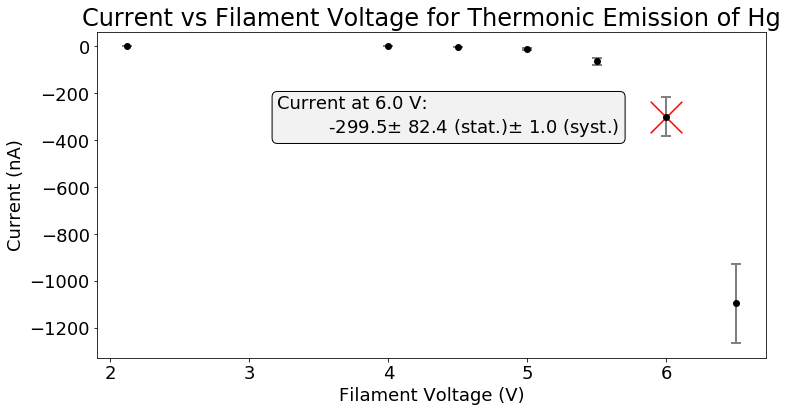

In [28]:
# bined data

bbox = dict(boxstyle="round", fc="0.95")

voltage = (thermon['V_f'] + thermon['V_f_2']) / 2
current = (thermon['V_f_current'] + thermon['V_f_current_2'])/2
err = np.std(np.array([thermon['V_f_current'], thermon['V_f_current_2']]) ,axis=0) /np.sqrt(2)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.scatter(6, current[5], marker='x', s=1000, c='r')
ax.errorbar(voltage, current, yerr=err, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
ax.set_title('Current vs Filament Voltage for Thermonic Emission of Hg')
ax.set_xlabel('Filament Voltage (V)')
ax.set_ylabel('Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

ax.annotate('Current at 6.0 V: \n\t {:.1f}'.format(current[5]) + r'$ \pm $' + ' {:.1f} (stat.)'.format(err[5]) + r'$ \pm $' + ' {:.1f} (syst.)'.format(thermon['V_f_current_unc'][5]), 
            xy=(.27, .8), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)

### Ionization

Effect of temp on mean free path of e-

In [233]:
ionization = pd.read_table('ionization.csv', sep=',')
ionization['temp_current_unc'] = ionization['temp_current_unc']*10
ionization['V_gc_current_unc'] = ionization['V_gc_current_unc']*5
ionization.head()

,temp,temp_current,temp_current_unc,V_gc,V_gc_current,V_gc_current_unc
0,35.0,0.12,0.1,19.80,16.2,0.5
1,52.0,0.20,0.1,19.63,14.7,0.5
2,60.0,1.16,0.1,19.58,14.2,0.5
3,70.0,2.38,0.1,19.55,13.9,0.5
4,79.0,4.24,0.1,19.50,13.6,0.5


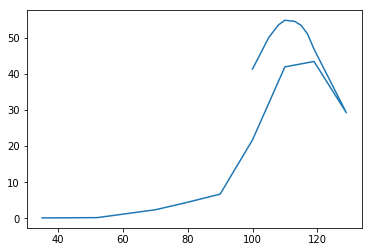

In [234]:
plt.plot(ionization['temp'], ionization['temp_current'])
plt.show()

In [235]:
# we need to correct for the drift in ampmeter
# do as a curve fit for gausian shape around peak with drift param


temps = ionization['temp'][6:18]
times = list()
times.append(0)
for i in range(7, 18):
    times.append(abs(ionization['temp'][i] - ionization['temp'][i-1]) + times[-1])
   # times.append(i)

In [236]:
from scipy.optimize import curve_fit
# set up a gaussian with drift
def drift_gauss(data, *p):
    x, t = data.reshape(2, -1)
    A, mu, sigma, drift = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + drift*t

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [30, 110, 10, .1]
popt, pcov = curve_fit(drift_gauss, np.ravel([temps, times]), ionization['temp_current'][6:18], p0=p0, sigma=ionization['temp_current_unc'][6:18])

print(popt)

[ 39.61379608 113.41010042  12.64227458   0.33268105]


In [237]:
# find bound on drift

def chi_squared(x, fit, sig):
     return np.sum(np.square(x-fit)/np.square(sig))

drift_change = 0.00719
new_fitup = drift_gauss(np.ravel([temps, times]), popt[0], popt[1], popt[2], popt[3]+drift_change)
new_fitdown = drift_gauss(np.ravel([temps, times]), popt[0], popt[1], popt[2], popt[3]-drift_change)

#find chi squareds
orig_chi = chi_squared(ionization['temp_current'][6:18], drift_gauss(np.ravel([temps, times]), *popt), ionization['temp_current_unc'][6:18])
up_chi = chi_squared(ionization['temp_current'][6:18], new_fitup, ionization['temp_current_unc'][6:18])
down_chi = chi_squared(ionization['temp_current'][6:18], new_fitdown, ionization['temp_current_unc'][6:18])
print('Chi Squared(Up): {:.2f}, Difference:{}'.format(up_chi, up_chi-orig_chi))
print('Reduced Chi Squared(Down): {:.2f}, Differnece: {}'.format(down_chi, down_chi-orig_chi))
print('Average Difference: {}\n'.format((up_chi+down_chi-2*orig_chi)/2))

print('Chi: ' + str(orig_chi))
print('dof: '  +str(len(temps)-len(popt)))
print('Reduced Chi: ' + str(orig_chi/(len(temps)-len(popt))))

Chi Squared(Up): 10.84, Difference:1.0005780703497411
Reduced Chi Squared(Down): 10.84, Differnece: 1.0005779606502294
Average Difference: 1.0005780154999862

Chi: 9.839219350986056
dof: 8
Reduced Chi: 1.229902418873257


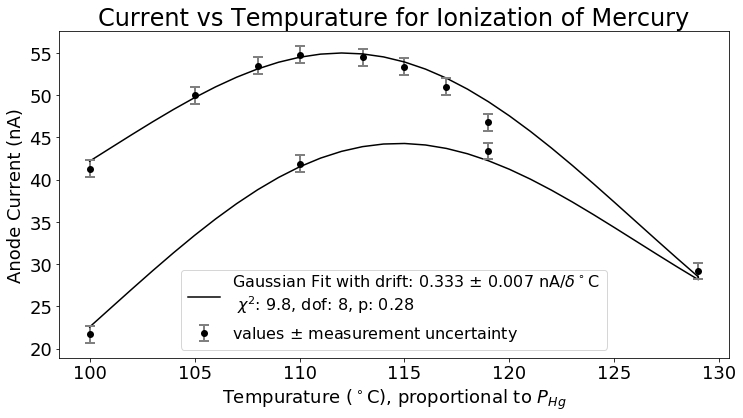

In [238]:
# get the fit
gauss_temps = np.linspace(np.min(ionization['temp'][6:18]), np.max(ionization['temp'][6:18]), 30)
gauss_temps = np.append(gauss_temps, gauss_temps[::-1])
data = np.ravel([gauss_temps, range(len(gauss_temps))])
corrected_fit = drift_gauss(data, *popt)

fig, ax = plt.subplots(1, figsize=(12, 6))

#make a fit label
fit_label = 'Gaussian Fit with drift: {:.3f} $\pm$ {:.3f} nA/$\delta^\circ$C'.format(popt[3], drift_change)
# p from http://courses.atlas.illinois.edu/spring2016/STAT/STAT200/pchisq.html
fit_label = fit_label + '\n $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi, len(temps)-len(popt), 0.2765)
ax.plot(gauss_temps, corrected_fit, 'black', label=fit_label)
ax.errorbar(temps, ionization['temp_current'][6:18], label='values $ \pm $ measurement uncertainty', yerr=ionization['temp_current_unc'][6:18], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Current vs Tempurature for Ionization of Mercury')
ax.set_xlabel('Tempurature ($^\circ$C), proportional to $P_{Hg}$')
ax.set_ylabel('Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)


#so drift is about .3326 per degree
ax.legend(fontsize=16)
plt.show()

In [239]:
# now plot corretcted for drift over full range

full_times = list()
full_times.append(0.0)
for i in range(1, 18):
    full_times.append(abs(ionization['temp'][i] - ionization['temp'][i-1]) + full_times[-1])
    #full_times.append(i)

drifts = [popt[3]*f for f in full_times]
corrected_current = ionization['temp_current'][:18] - drifts
drift_uncerts = [drift_change * f + 2*popt[3] for f in full_times]

# combine 6, 17 and 7, 14
corrected_current[17] = (corrected_current[6] + corrected_current[17])/2
corrected_current[14] = (corrected_current[7] + corrected_current[14])/2
corrected_current[10] = (corrected_current[8] + corrected_current[10])/2

Text(0.23,0.5,'Current at 110$^\\circ$C: \n\t 38.8 $ \\pm $ 1.0 (stat.) $ \\pm $ 1.5 (syst.) nA')

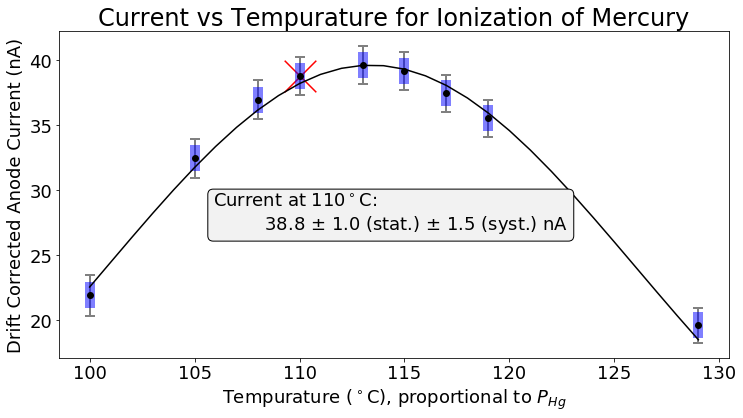

In [240]:
# make a pretty plot

# drift corrected fit
gauss_temps = np.linspace(np.min(ionization['temp'][6:18]), np.max(ionization['temp'][6:18]), 30)
data = np.ravel([gauss_temps, np.zeros(len(gauss_temps))])
corrected_fit = drift_gauss(data, *popt)


fig, ax = plt.subplots(1, figsize=(12, 6))
# plot fit
ax.plot(gauss_temps, corrected_fit, 'black', label='fit A=%2.1f, mean=%5.0f, sigma=%1.0f' % tuple(popt[:3]))
# plot points and uncertainty from drifts (systematic)
ax.errorbar(temps[3:], corrected_current[9:18] + ionization['temp_current'][6], yerr=drift_uncerts[9:18], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
# plot uncertainty from repeated measurments and measurment uncertainty 
stat_uncerts = ionization['temp_current_unc'][9:18]
ax.errorbar(temps[3:], corrected_current[9:18] + ionization['temp_current'][6], yerr=stat_uncerts, fmt='None', c='red', alpha=0.5, ecolor='blue', capsize=0, elinewidth=10, markeredgewidth=2, ms=10)

ax.set_title('Current vs Tempurature for Ionization of Mercury')
ax.set_xlabel('Tempurature ($^\circ$C), proportional to $P_{Hg}$')
ax.set_ylabel('Drift Corrected Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

plt.scatter(110, corrected_current[14] + ionization['temp_current'][6], marker='x', s=1000, c='r')
ax.annotate('Current at 110$^\circ$C: \n\t {:.1f} $ \pm $ {:.1f} (stat.) $ \pm $ {:.1f} (syst.) nA'.format(corrected_current[14] + ionization['temp_current'][6], ionization['temp_current_unc'][14], drift_uncerts[14]), 
            xy=(.23, .5), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


### Ionization
yay

In [285]:
# do some sort of fit??
# before the knee, so 
def lines(data, *p):
    m1, b1, m2, b2 = p
    one = m1*data+b1
    two = m2*data+b2
    return np.maximum(one, two)


def line(data, *p):
    m1, b1 = p
    one = m1*data+b1
    return one


voltages = ionization['V_gc']
currents = ionization['V_gc_current']
uncerts = ionization['V_gc_current_unc']*10

# p0 is the initial guess for the fitting coefficients 
p0 = [.1, 0, 8, -100]
popt, pcov = curve_fit(lines, voltages, currents, p0=p0, sigma=uncerts)
print(popt)
log_volts = np.linspace(np.min(voltages), np.max(voltages), 50)
log_corrected_fit = lines(log_volts, *popt)

p0 = [8, -100]
voltages2 = ionization[ionization['V_gc_current']>10]['V_gc']
currents2 = ionization[ionization['V_gc_current']>10]['V_gc_current']
uncerts2 = ionization[ionization['V_gc_current']>10]['V_gc_current_unc']*10
popt2, pcov2 = curve_fit(line, voltages2, currents2, p0=p0, sigma=uncerts2)
print(popt2)

[   0.24214261   -2.84357195   10.16156131 -193.66550831]
[   8.14970998 -146.28250035]


In [286]:
# find the intercepts
intercept = (popt[3]-popt[1])/(popt[0]-popt[2])
intercept2 = (popt2[1]-popt[1])/(popt[0]-popt2[0])
print(intercept)
print(intercept2)
print('\n\n')

# find bounds on the intercepts 
mu1_change = .039
b1_change=.8

mu2_change = .059
b2_change=1.31


#find chi squareds
orig_chi_1 = chi_squared(currents, lines(voltages, *popt), uncerts)
up_chi_m1 = chi_squared(currents, lines(voltages, *popt[:2], popt[2] + mu1_change, popt[3]), uncerts)
down_chi_m1 = chi_squared(currents, lines(voltages, *popt[:2], popt[2] - mu1_change, popt[3]), uncerts)
#print('M1 Chi Squared(Up): {:.2f}, Difference:{}'.format(up_chi, up_chi-orig_chi))
#print('Reduced Chi Squared(Down): {:.2f}, Differnece: {}'.format(down_chi, down_chi-orig_chi))
print('M1 Average Difference: {}\n'.format((up_chi_m1+down_chi_m1-2*orig_chi_1)/2))
                                          
up_chi_b1 = chi_squared(currents, lines(voltages, *popt[:3], popt[3] + b1_change), uncerts)
down_chi_b1 = chi_squared(currents, lines(voltages, *popt[:3], popt[3] - b1_change), uncerts)
print('B1 Average Difference: {}\n'.format((up_chi_b1+down_chi_b1-2*orig_chi_1)/2))

orig_chi_2 = chi_squared(currents2, line(voltages2, *popt2), uncerts2)
up_chi_b2 = chi_squared(currents2, line(voltages2, popt2[0], popt2[1] + b2_change), uncerts2)
down_chi_b2 = chi_squared(currents2, line(voltages2, popt2[0], popt2[1] - b2_change), uncerts2)
print('B2 Average Difference: {}\n'.format((up_chi_b2+down_chi_b2-2*orig_chi_2)/2))
up_chi_m2 = chi_squared(currents2, line(voltages2, popt2[0]+mu2_change, popt2[1]), uncerts2)
down_chi_m2 = chi_squared(currents2, line(voltages2, popt2[0]-mu2_change, popt2[1]), uncerts2)
print('M2 Average Difference: {}\n'.format((up_chi_m2+down_chi_m2-2*orig_chi_2)/2))
                                          

print('Chi: ' + str(orig_chi_2))
print('dof: '  +str(len(voltages)-len(popt)))
print('Reduced Chi: ' + str(orig_chi/(len(voltages)-len(popt))))

# find intercept changes
dint_1 = max(abs((popt[3]+b1_change-popt[1])/(popt[0]-popt[2]-mu1_change) - intercept), abs((popt[3]-popt[1]-b1_change)/(popt[0]-popt[2]+mu1_change) -intercept))
dint_2 = max(abs((popt2[1]+b2_change-popt[1])/(popt[0]-popt2[0]-mu2_change) - intercept2), abs((popt2[1]-popt[1]-b2_change)/(popt[0]-popt2[0]+mu2_change) -intercept2))
print('intercept one: {} +- {}'.format(intercept, dint_1))
print('intercept two: {} +- {}'.format(intercept2, dint_2))

19.237209556090253
18.139450672498054



M1 Average Difference: 1.0306970279098593

B1 Average Difference: 1.0381408955432505

B2 Average Difference: 1.0296600000000036

M2 Average Difference: 1.0042609949639778

Chi: 0.8388160719803814
dof: 20
Reduced Chi: 1480269.1902579335
intercept one: 19.237209556090253 +- 0.15690136405046218
intercept two: 18.139450672498054 +- 0.3032690521575958


Text(0.03,0.5,'Ionization + Contact Potential: \n\t19.24 $ \\pm $ 1.10 (syst.) $ \\pm $ 0.34 (stat.) V')

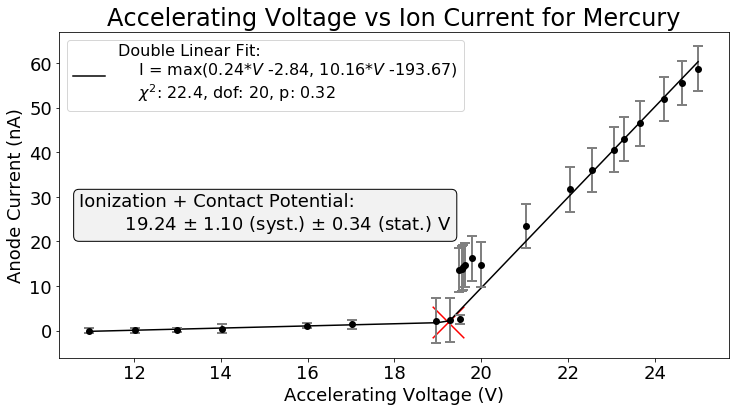

In [287]:
# make a pretty plot

fig, ax = plt.subplots(1, figsize=(12, 6))

# plot the fit
log_fit_label = 'Double Linear Fit: \n    I = max({:1.2f}$*V$ {:1.2f}, {:1.2f}$*V$ {:1.2f})'.format(*popt) 
log_fit_label  = log_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi_1, len(voltages)-len(popt), 0.3192)
ax.plot(log_volts, log_corrected_fit, 'black', label=log_fit_label)

# plot the points
ax.errorbar(ionization['V_gc'], ionization['V_gc_current'], label=None, yerr=uncerts, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Accelerating Voltage vs Ion Current for Mercury')
ax.set_xlabel('Accelerating Voltage (V)')
ax.set_ylabel('Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)
ax.legend(fontsize=16)
ax.scatter(intercept, popt[0]*intercept+popt[1] , marker='x', s=1000, c='r', linewidths=10)


ax.annotate('Ionization + Contact Potential: \n\t{:.2f} '.format(intercept) + r'$ \pm $' + ' {:.2f} (syst.) '.format(intercept-intercept2) + r'$ \pm $' + ' {:.2f} (stat.) V'.format(np.sqrt(dint_1**2 + dint_2**2)), 
            xy=(.03, .5), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


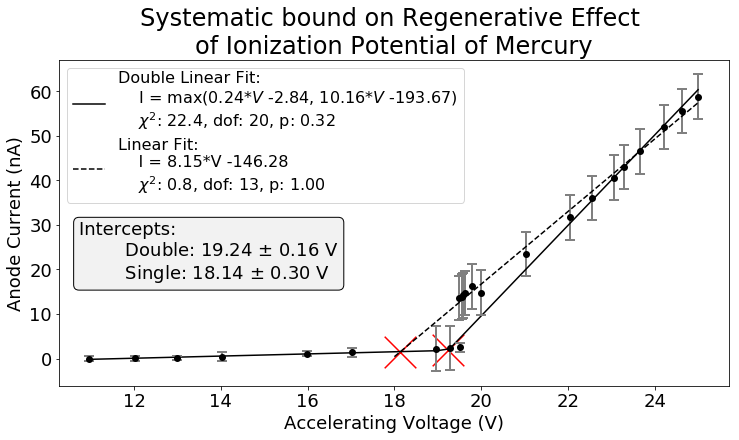

In [288]:
# make a pretty plot

fig, ax = plt.subplots(1, figsize=(12, 6))
# plot the double linear fit
ax.plot(log_volts, log_corrected_fit, 'black', label=log_fit_label)

# plot the points
ax.errorbar(ionization['V_gc'], ionization['V_gc_current'], yerr=uncerts, label=None, fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Systematic bound on Regenerative Effect \nof Ionization Potential of Mercury')
ax.set_xlabel('Accelerating Voltage (V)')
ax.set_ylabel('Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

# plot the slingle linear fit
log_volts = np.linspace(18, np.max(voltages), 50)
log_corrected_fit = line(log_volts, *popt2)
log_fit_label = 'Linear Fit: \n    I = {:1.2f}*V {:1.2f}'.format(*popt2) 
log_fit_label  = log_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi_2, len(voltages2)-len(popt2), 1)
ax.plot(log_volts, log_corrected_fit, 'black', label=log_fit_label, linestyle='--')
ax.legend(fontsize=16)
ax.scatter(intercept, popt[0]*intercept+popt[1] , marker='x', s=1000, c='r', linewidths=10)
ax.scatter(intercept2, popt2[0]*intercept2+popt2[1], marker='x', s=1000, c='r', linewidths=10)

ax.annotate('Intercepts: \n\tDouble: {:.2f} $ \pm $ {:.2f} V\n\tSingle: {:.2f} $ \pm $ {:.2f} V'.format(intercept, dint_1, intercept2, dint_2), 
            xy=(.03, .5), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


plt.show()

In [388]:
excite = pd.read_table('excitaion.csv', sep=',')
excite['unc_1'] =excite['unc_1']*3
excite['unc_2'] =excite['unc_2']*3
excite['unc_3'] =excite['unc_3']*3

excite.head()

,V_gc_1,current_1,unc_1,V_gc_2,current_2,unc_2,V_gc_3,current_3,unc_3
0,0.042,0.01,0.06,0.0412,-0.001,0.009,5.00,-0.001,0.003
1,1.056,-0.01,0.06,5.0000,-0.002,0.009,9.99,-0.040,0.090
2,2.021,0.01,0.06,10.0100,-0.040,0.060,11.01,-0.200,0.300
3,3.027,0.01,0.06,11.0000,-0.015,0.120,12.00,-14.000,0.600
4,4.020,0.01,0.06,12.0000,-24.000,3.000,13.00,-22.000,3.000


In [389]:
# for retarding diff
excite['V_gc_1'] = excite['V_gc_1'] + 1.1 -.512
#excite['V_gc_2'] = excite['V_gc_2'] - 1.1
#excite['V_gc_3'] = excite['V_gc_3'] - 1.1
excite.head()

,V_gc_1,current_1,unc_1,V_gc_2,current_2,unc_2,V_gc_3,current_3,unc_3
0,0.630,0.01,0.06,0.0412,-0.001,0.009,5.00,-0.001,0.003
1,1.644,-0.01,0.06,5.0000,-0.002,0.009,9.99,-0.040,0.090
2,2.609,0.01,0.06,10.0100,-0.040,0.060,11.01,-0.200,0.300
3,3.615,0.01,0.06,11.0000,-0.015,0.120,12.00,-14.000,0.600
4,4.608,0.01,0.06,12.0000,-24.000,3.000,13.00,-22.000,3.000


In [390]:
# do a curve fit 
p0 = [.1, 0, 8, -100]
ovolts = np.append(excite['V_gc_1'], excite['V_gc_2'])
ovolts = np.append(ovolts, excite['V_gc_3'])
ovolts = ovolts[np.logical_not(np.isnan(ovolts))]
volts = ovolts[ovolts<13]

currents = np.append(-excite['current_1'], -excite['current_2'])
currents = np.append(currents, -excite['current_3'])
currents = currents[np.logical_not(np.isnan(currents))]
currents = currents[ovolts<13]
uncerts = np.append(excite['unc_1'], excite['unc_2'])
uncerts = np.append(uncerts, excite['unc_3'])
uncerts = uncerts[np.logical_not(np.isnan(uncerts))]
uncerts = uncerts[ovolts<13]

popt, pcov = curve_fit(lines, volts, currents, p0=p0, sigma=uncerts)
print(popt)

# find the intercept
intercept = (popt[3]-popt[1])/(popt[0]-popt[2])
print(intercept)

# find bounds on the intercepts 
mu_change = .0041
b_change=.045


#find chi squareds
orig_chi = chi_squared(currents, lines(volts, *popt), uncerts)
up_chi_m = chi_squared(currents, lines(volts, *popt[:2], popt[2] + mu_change, popt[3]), uncerts)
down_chi_m = chi_squared(currents, lines(volts, *popt[:2], popt[2] - mu_change, popt[3]), uncerts)
print(orig_chi)
print(up_chi_m)
print(down_chi_m)
print('Mu Average Difference: {}\n'.format((up_chi_m+down_chi_m-2*orig_chi)/2))
                                          
up_chi_b = chi_squared(currents, lines(volts, *popt[:3], popt[3] + b_change), uncerts)
down_chi_b = chi_squared(currents, lines(volts, *popt[:3], popt[3] - b_change), uncerts)
print('B Average Difference: {}\n'.format((up_chi_b+down_chi_b-2*orig_chi)/2))                                        

print('Chi: ' + str(orig_chi))
print('dof: '  +str(len(volts)-len(popt)))
print('Reduced Chi: ' + str(orig_chi/(len(volts)-len(popt))))

# find intercept changes
dint = max(abs((popt[3]+b1_change-popt[1])/(popt[0]-popt[2]-mu1_change) - intercept), abs((popt[3]-popt[1]-b1_change)/(popt[0]-popt[2]+mu1_change) -intercept))
print('intercept one: {} +- {}'.format(intercept, dint))

[ 4.33929399e-04 -8.27838342e-04  1.32925349e+01 -1.46188548e+02]
10.998089773965436
58.189304984738854
58.3608176603056
58.303581506851906
Mu Average Difference: 0.1428945988399022

B Average Difference: 0.14107646393685513

Chi: 58.189304984738854
dof: 24
Reduced Chi: 2.424554374364119
intercept one: 10.998089773965436 +- 0.09272739281681552


10.998089773965436


Text(0.03,0.8,'Contact Potential:\n\t9.90 $ \\pm $ 0.09 (stat.)$ \\pm $ 0.03 (syst.) V')

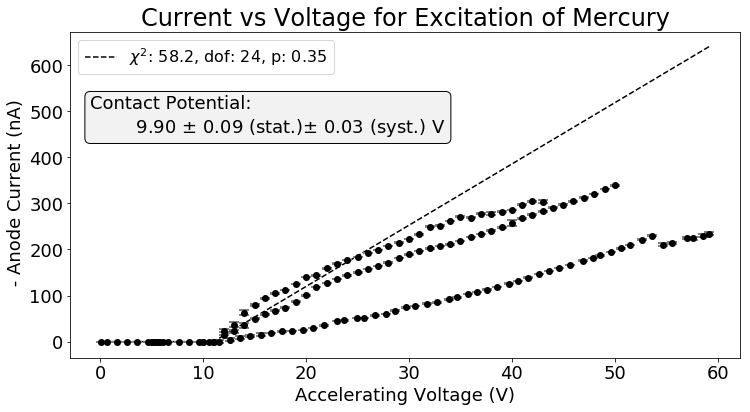

In [391]:
# make a pretty plot

fig, ax = plt.subplots(1, figsize=(12, 6))

log_volts = np.linspace(np.min(volts), np.max(ovolts), 100)
log_corrected_fit = lines(log_volts, *popt)
log_fit_label  = '$\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(orig_chi, len(volts)-len(popt), 0.3503)

ax.plot(log_volts, log_corrected_fit, 'black', linestyle='--', label=log_fit_label)
ax.legend(fontsize=16)
ax.errorbar(excite['V_gc_1'],-excite['current_1'], yerr=excite['unc_1'], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
ax.errorbar(excite['V_gc_2'],-excite['current_2'], yerr=excite['unc_2'], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)
ax.errorbar(excite['V_gc_3'],-excite['current_3'], yerr=excite['unc_3'], fmt='.', c='black', ecolor='grey', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

ax.set_title('Current vs Voltage for Excitation of Mercury')
ax.set_xlabel('Accelerating Voltage (V)')
ax.set_ylabel(' - Anode Current (nA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)


intercept = (popt[3]-popt[1])/(popt[0]-popt[2])
print(intercept)
# .03 system from uncertainty in subtracting Vr
ax.annotate('Contact Potential:\n\t{:.2f} '.format(intercept-1.1) + r'$ \pm $' + ' {:.2f} (stat.)'.format(dint) 
            + r'$ \pm $' + ' {:.2f} (syst.) V'.format(.03), 
            xy=(.03, .8), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)


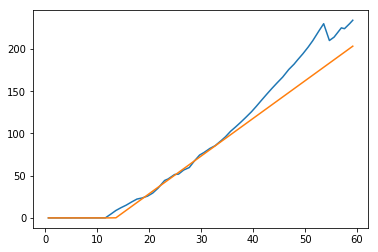

/home/kal/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in maximum
  import sys


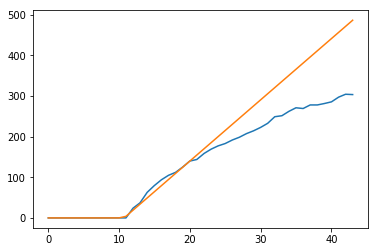

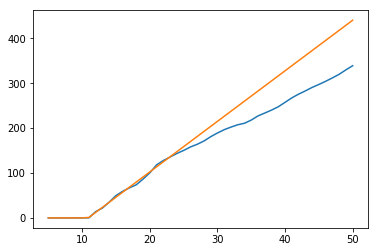

In [370]:
# try to get good excitation data
# look only at first bit?? before on linear effects begin - up until 30

fit=dict()
diffs=dict()
for i in range(1,4):
    volts = excite[excite['V_gc_'+str(i)]<25]['V_gc_'+str(i)][np.logical_not(np.isnan(excite['V_gc_'+str(i)]))]
    currents = excite[excite['V_gc_'+str(i)]<25]['current_'+str(i)][np.logical_not(np.isnan(excite['current_'+str(i)]))]
    uncerts = excite[excite['V_gc_'+str(i)]<25]['unc_'+str(i)][np.logical_not(np.isnan(excite['unc_'+str(i)]))]

    p0 = [.1, 0, 8, -100]
    popt, pcov = curve_fit(lines, volts, -currents, p0=p0, sigma=uncerts)

    fit[i] = lines(excite['V_gc_'+str(i)], *popt)
    plt.plot(excite['V_gc_'+str(i)], -excite['current_'+str(i)])
    plt.plot(excite['V_gc_'+str(i)], fit[i])
    plt.show()

    diffs[i] = fit[i] + excite['current_'+str(i)]

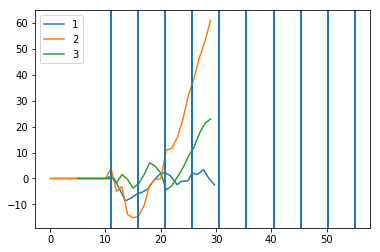

In [371]:
for i in range(1, 4):
    plt.plot(excite[excite['V_gc_'+str(i)]<30]['V_gc_'+str(i)], diffs[i][excite['V_gc_'+str(i)]<30], label=i)
    plt.legend()
    for x in [4.9*i + 11 for i in range(10)]:
        plt.axvline(x=x)
plt.show()

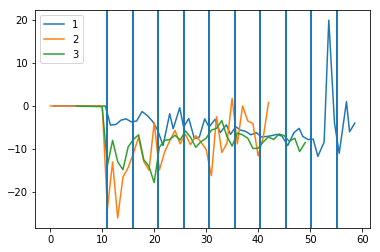

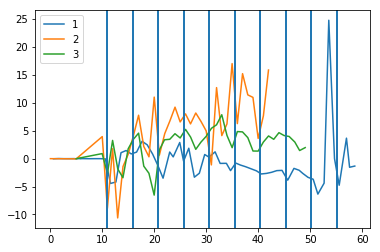

In [387]:
for i in range(1, 4):
    slope = [a-b for a,b in zip(excite['current_'+str(i)][1:], excite['current_'+str(i)][:-1])]
    plt.plot(excite['V_gc_'+str(i)][:-1], slope, label=i)
    plt.legend()
    for x in [4.9*i + 11 for i in range(10)]:
        plt.axvline(x=x)
plt.show()


for i in range(1, 4):
    slope = [a-b for a,b in zip(diffs[i][1:], diffs[i][:-1])]
    plt.plot(excite['V_gc_'+str(i)][:-1], slope, label=i)
    plt.legend()
    for x in [4.9*i + 11 for i in range(10)]:
        plt.axvline(x=x)
plt.show()

In [373]:
a = list(range(10))
print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [374]:
a[:-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [375]:
a[1:]

[1, 2, 3, 4, 5, 6, 7, 8, 9]